<a href="https://colab.research.google.com/github/yordanovagabriela/neuralnetworks/blob/master/House_Prices_Clusterization_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.utils.linear_assignment_ import linear_assignment
import sklearn.metrics
import seaborn as sns
from tensorflow import keras

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load Dataset

In [137]:
dataset = pd.read_csv('./kc_house_data.csv')
dataset.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Preprocess Data

## Cleanup Columns

In [138]:
del dataset['id']
del dataset['date']
del dataset['zipcode']

## Check for Unknown Values

In [139]:
dataset.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Split Features from Labels

In [140]:
X = dataset.drop('view',axis=1)
y = dataset['view']
y.unique()

array([0, 3, 4, 2, 1])

## Normalize Data

In [141]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(X)

## Split Data into Train, Validation and Test Set

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [143]:
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 12967
Validation set size: 4323
Test set size: 4323


# Build Model

## KMeans

In [144]:
total_accuracy = 0
for i in range(10):
  kmeans = KMeans(n_clusters=5, n_init=20, n_jobs=1)
  y_pred_kmeans = kmeans.fit_predict(X)
  total_accuracy += sklearn.metrics.accuracy_score(y.values, y_pred_kmeans)
  print("Accuracy with kMeans:", sklearn.metrics.accuracy_score(y.values, y_pred_kmeans))

Accuracy with kMeans: 0.1518993198537917
Accuracy with kMeans: 0.3398880303521029
Accuracy with kMeans: 0.14537546846805163
Accuracy with kMeans: 0.3390551982603063
Accuracy with kMeans: 0.43284134548651276
Accuracy with kMeans: 0.4448711423680192
Accuracy with kMeans: 0.3381298292694212
Accuracy with kMeans: 0.43797714338592514
Accuracy with kMeans: 0.43779206958774813
Accuracy with kMeans: 0.14560681071577292


In [145]:
print("Average accuracy from 10 runs: {}".format(total_accuracy / 10))

Average accuracy from 10 runs: 0.32134363577476516


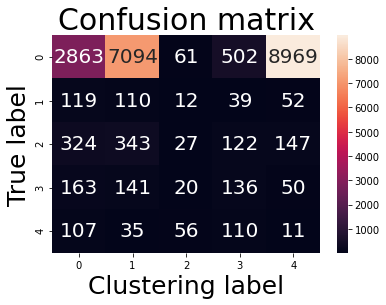

In [146]:
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred_kmeans)
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Deep Autoencoder

In [147]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    n_stacks = len(dims) - 1
    
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img

    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    x = BatchNormalization()(x)
    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [148]:
dims = [X.shape[-1], 64, 64, 5]
pretrain_optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256

In [149]:
autoencoder, encoder = autoencoder(dims)

In [150]:
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 64)                1152      
_________________________________________________________________
encoder_1 (Dense)            (None, 64)                4160      
_________________________________________________________________
encoder_2 (Dense)            (None, 5)                 325       
_________________________________________________________________
decoder_2 (Dense)            (None, 64)                384       
_________________________________________________________________
decoder_1 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256      

In [151]:
autoencoder.compile(optimizer='rmsprop', loss='mean_squared_logarithmic_error')
autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), batch_size=64, epochs=100)

Train on 12967 samples, validate on 4323 samples
Epoch 1/100
12967/12967 [==============================] - 1s 49us/step - loss: 29.6964 - val_loss: 28.1939
Epoch 2/100
12967/12967 [==============================] - 0s 33us/step - loss: 21.9722 - val_loss: 19.6675
Epoch 3/100
12967/12967 [==============================] - 0s 32us/step - loss: 16.9283 - val_loss: 15.0279
Epoch 4/100
12967/12967 [==============================] - 0s 34us/step - loss: 13.8211 - val_loss: 12.5323
Epoch 5/100
12967/12967 [==============================] - 0s 33us/step - loss: 11.7157 - val_loss: 10.7270
Epoch 6/100
12967/12967 [==============================] - 0s 33us/step - loss: 10.1969 - val_loss: 9.4539
Epoch 7/100
12967/12967 [==============================] - 0s 34us/step - loss: 9.0289 - val_loss: 7.2986
Epoch 8/100
12967/12967 [==============================] - 0s 32us/step - loss: 8.0798 - val_loss: 7.7520
Epoch 9/100
12967/12967 [==============================] - 0s 33us/step - loss: 7.2012 - val

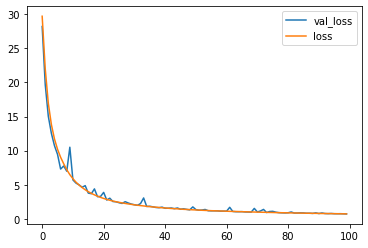

In [152]:
losses = pd.DataFrame(autoencoder.history.history)
losses[['val_loss', 'loss']].plot()

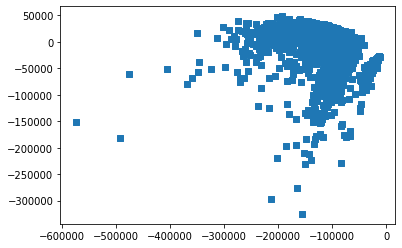

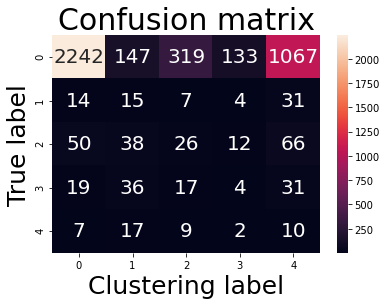

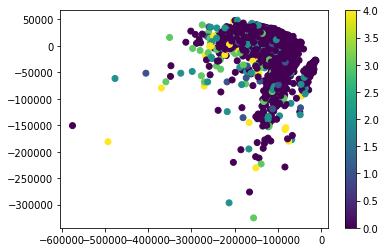

In [153]:
encoding = encoder.predict(X_test)

plt.scatter(encoding[:, 0], encoding[:, 1], marker="s", s=40, cmap="RdBu")
plt.show()

km = KMeans(n_clusters=5, n_init=20, n_jobs=1)

y_pred = km.fit_predict(encoding)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

plt.scatter(encoding[:, 0], encoding[:, 1], c=y_test)
plt.colorbar()
plt.show()


In [154]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.5313439740920657

In [155]:
autoencoder.save('clust_model')

In [158]:
k = KMeans(n_clusters=5, n_init=20, n_jobs=1)
y_kmeans = k.fit_predict(X_test)
sklearn.metrics.accuracy_score(y_test.values, y_kmeans)

0.4251677076104557